<a href="https://colab.research.google.com/github/kungfumas/aplikasi-deep-learning/blob/master/notebooks/iris_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Packages

In [53]:
import sys

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates, andrews_curves, radviz, scatter_matrix
import seaborn as sns

import sklearn
from scipy import stats

from IPython.display import set_matplotlib_formats
matplotlib.style.use('ggplot') # Other styles matplotlib.style.available
import os
from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline
sns.set_context('notebook')
plt.close('all')

## Load Dataset

In [54]:
url = 'https://raw.githubusercontent.com/kungfumas/aplikasi-deep-learning/master/Iris.csv'
iris = pd.read_csv(url)
iris.rename(columns={'Name':'Species'},inplace=True)

## Data preparation

In [55]:
print(iris.info())
iris.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
count,150.000000,150.000000,150.000000,150.000000,150.000000,150
unique,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,Iris-setosa
freq,NaN,NaN,NaN,NaN,NaN,50
mean,75.500000,5.843333,3.054000,3.758667,1.198667,NaN
std,43.445368,0.828066,0.433594,1.764420,0.763161,NaN
min,1.000000,4.300000,2.000000,1.000000,0.100000,NaN
25%,38.250000,5.100000,2.800000,1.600000,0.300000,NaN
50%,75.500000,5.800000,3.000000,4.350000,1.300000,NaN
75%,112.750000,6.400000,3.300000,5.100000,1.800000,NaN


Species is stored as an object, instead of as categorical variable, this will not be ideal since is our target varible. It would be best to store it as a categorical variable

In [56]:
iris.Species = iris.Species.astype('category')
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             150 non-null    int64   
 1   SepalLengthCm  150 non-null    float64 
 2   SepalWidthCm   150 non-null    float64 
 3   PetalLengthCm  150 non-null    float64 
 4   PetalWidthCm   150 non-null    float64 
 5   Species        150 non-null    category
dtypes: category(1), float64(4), int64(1)
memory usage: 6.3 KB


## The first four moments _of the iris statistical distribution_
The moments desribing the shape of the iris dataset distribution:

1) The mean (which indicates the central tendency of a distribution): varies across all Species for each feature, except for Sepal measurements in setosa and versicolor, which are relatively similar 

2) Variance (indicates the width or deviation): PetalWidthCm has narrow deviations from the mean for all Species, while SepalWidthCm has a slightly wider variation for all Species. Sepal and Petal length have much wider deviation

3) Skewness (indicates asymmetric ‘leaning’ to either left or right): Versicolor measurements are all negatively skewed, except for SepalLengthCm, Virginica measurements are all positively skewed, except PetalWidthCm.

4) The Kurtosis, which indicates the degree of central ‘peakedness’ or, equivalently, the ‘fatness’ of the outer tails, indicates how much the distribution is influence by outliers. The distribution of PetalLengthCm and PetalWidthCm are negatively influenced by outliers

In [57]:
metrics = ['count', 'min', 'max', 'mean','std','skew']
iris.groupby(by='Species').agg(metrics)

Id                                 SepalLengthCm            \
                count  min  max   mean       std skew         count  min  max   
Species                                                                         
Iris-setosa        50    1   50   25.5  14.57738  0.0            50  4.3  5.8   
Iris-versicolor    50   51  100   75.5  14.57738  0.0            50  4.9  7.0   
Iris-virginica     50  101  150  125.5  14.57738  0.0            50  4.9  7.9   

                        ... PetalLengthCm                             \
                  mean  ...           max   mean       std      skew   
Species                 ...                                            
Iris-setosa      5.006  ...           1.9  1.464  0.173511  0.071846   
Iris-versicolor  5.936  ...           5.1  4.260  0.469911 -0.606508   
Iris-virginica   6.588  ...           6.9  5.552  0.551895  0.549445   

                PetalWidthCm                                       
                       count  min  max   mean       std      skew  
Species                                                            
Iris-setosa               50  0.1  0.6  0.244  0.107210  1.197243  
Iris-versicolor           50  1.0  1.8  1.326  0.197753 -0.031180  
Iris-virginica            50  1.4  2.5  2.026  0.274650 -0.129477  

[3 rows x 30 columns]

In [58]:
iris.apply('kurtosis')

Id              -1.200000
SepalLengthCm   -0.552064
SepalWidthCm     0.290781
PetalLengthCm   -1.401921
PetalWidthCm    -1.339754
dtype: float64

---

# Exploratory data visualisation

Before modelling, we have to first of all ensure that there are no obvious groups that do not require clustering unnecessary sophisticated modelling to exploit to explain variations in our dataset. 

This is important in case our model introduces artefacts or does not achieve an optimum clustering outcome. Moreover, we would like to get a better understanding of our dataset to update our ground truth knowledge to develop better hypotheses we can test against our model outcomes. This is also important to address any confounding concerns for our decision to model relationships that might not be picked by our model or might be affected by our model.

### Box plot

Based on the distribution of values within each column, sepal width and sepal length seem like weak discriminators for classification. At least 2 of the characteristics, petal length and petal width look like promising features to distinguish differerent Species.


The whiskers extend from the edges of box to show the range of the data. The position of the whiskers is set by default to 1.5 \* IQR (IQR = Q3 - Q1) from the edges of the box. Outlier points are those past the end of the whiskers. Outliers in some of the features need to be excluded from the dataset for models sensitive to outliers like k-means clustering

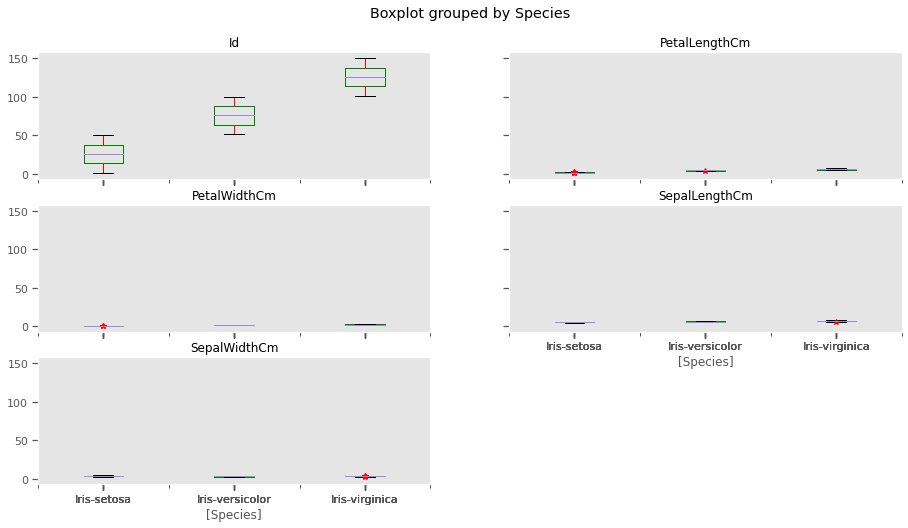

In [59]:
iris.boxplot(by='Species', figsize=(15, 8),color={'boxes':'Green','whiskers':'Red'},sym='r*', grid=False)
plt.show()

### Histograms and Kernel Density estimation

The scale of measurements for length are conflated,  but not so much for width. This might affect clustering outcomes should we choose variables with similar measurements.

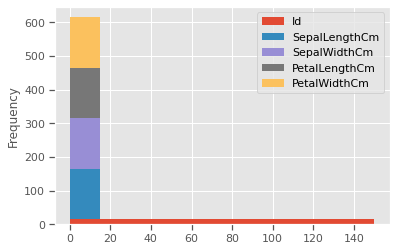

In [60]:
iris.plot.hist(stacked=True,by='Species')
plt.show()

THe kernel density estimation (KDE) is a non-parametric way to estimate the probability density function (PDF) of a random variable. This function uses Gaussian kernels and includes automatic bandwidth determination. This plot estimates how normally distributed the features are. Petal width and petal length seem to be bi-normally distributed with some overlap, and could be weak discriminators

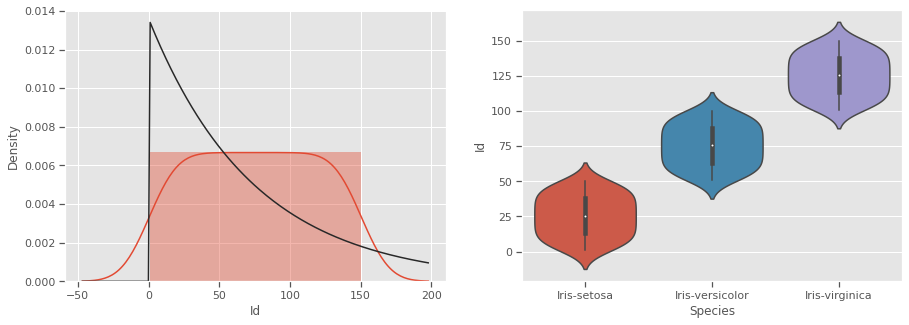

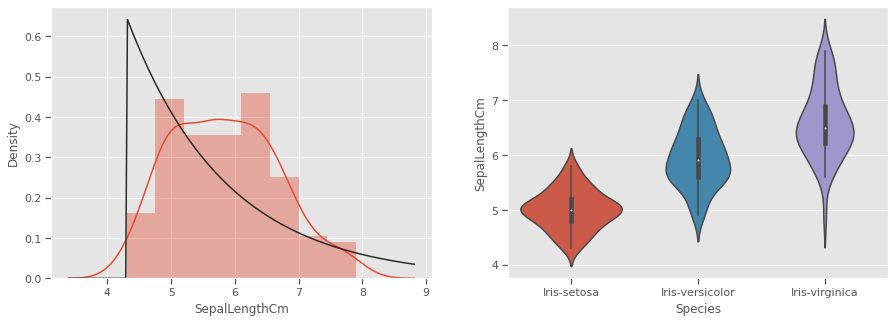

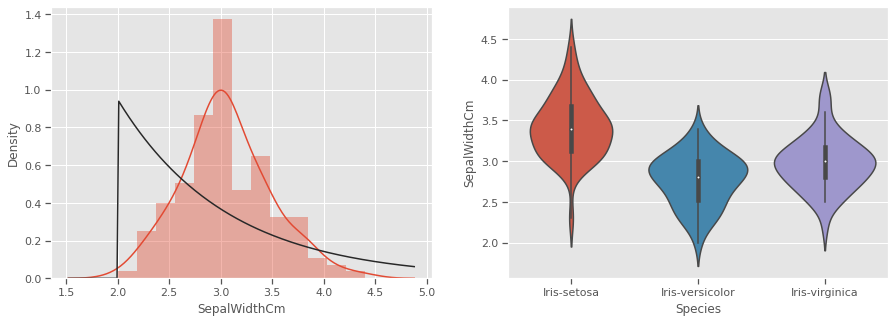

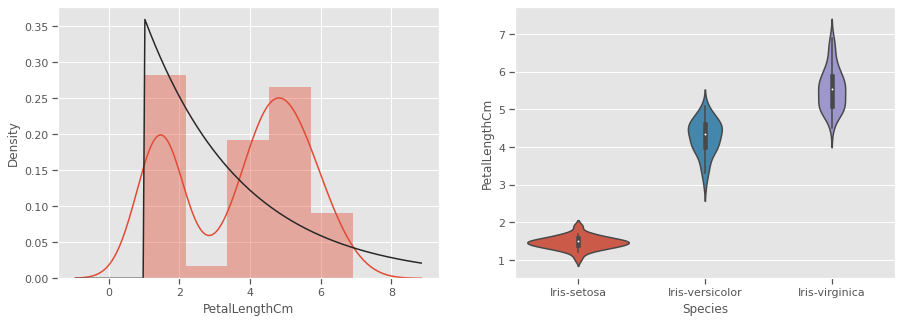

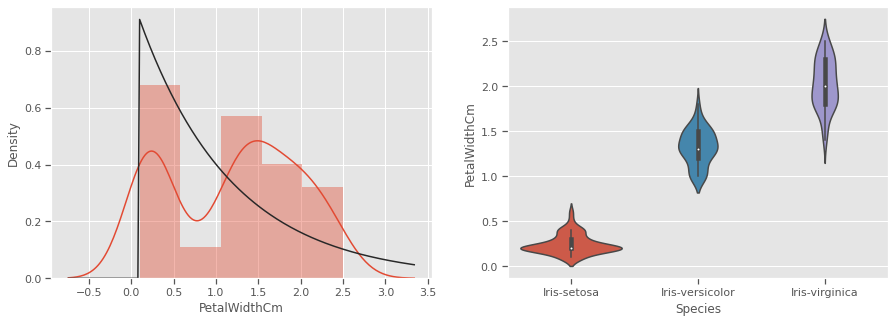

In [61]:
feats = iris.drop(columns=['Species'])
for col in feats.columns:
  fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5), sharex=False)
  sns.distplot(iris[col],fit=stats.expon,hist=True,kde=True,ax=ax1)
  sns.violinplot(data=iris,x='Species',y=col,inner='box',ax=ax2)
  plt.show()

Petals measurements are bi-normally distributed and might make clustering using this feature as a discriminator

## Multivariate analysis

There is no confounding evidence of clusters forming based on univariate properties for any of the Species. We will now explore multivariate interactions and the possibility of natural clusters forming. We would like the null hypothesis that "it is not possible to cluster all three iris Species based on the Length and Width of Sepal and Petals"

### Pairwise comparison 

Sometimes variables measuring properties of the same entity have positive/negative re-enforcing effects, especially for biochemical systems like genetic phenotypical measurements. In our case Sepal and Petal properties might be genetically linked or depedent on each other in different Species. Sepal measurements are seem like weak predictors of Species, and will to cluster all three Species. Petal measurements have a potential, but not strongly enough in pairwise relationships. 

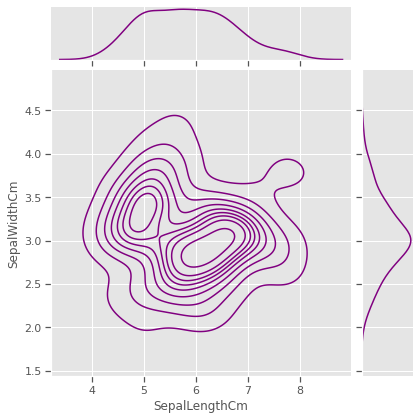

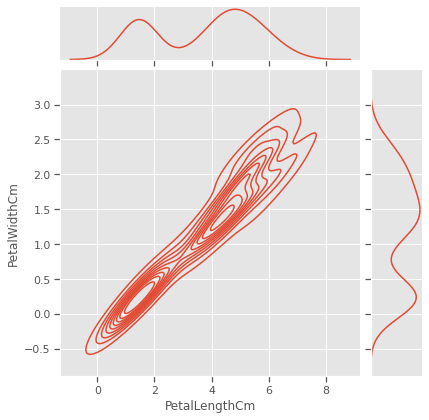

In [62]:
sns.jointplot(data=iris,x='SepalLengthCm',y='SepalWidthCm',kind='kde',color="Purple")
sns.jointplot(data=iris,x='PetalLengthCm',y='PetalWidthCm',kind='kde')
plt.savefig("kde.png")
plt.show()

### Scatterplot

We would like to test Sepal measurements against the Species to see how much each Species differs from the rest, and if skewness and kurtosis influencing natural formation of clusters. Species setosa has above average SepalWidthCm, but below average SepalLengthCm, while versicolor is the exact opposite. Virginica has relatively above average SepalLengthCm and SepalWidthCm.Sepal properties seem to have no generalisable Species specific patterns. For example, just by looking at Species setosa and versicolor, one might be tempted to think that Species with wider sepals have shorter sepals as well, but that is not the case for virginica. Prior knowledge of the genetics for these Species confirms that 

Kurtosis:-1.34


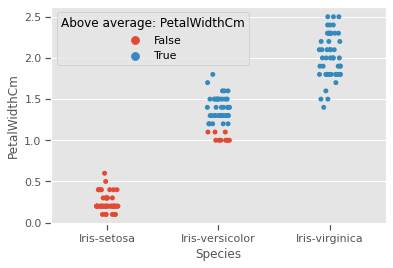

Kurtosis:-1.4


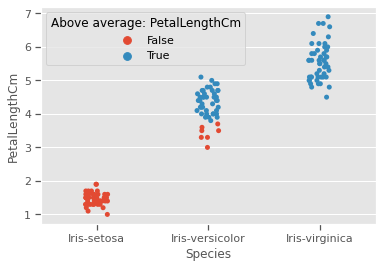

In [63]:
list_sepals = ("PetalWidthCm","PetalLengthCm")
sepals = iris.copy()
for s in list_sepals:
  sepals[f'Above average: {s}'] = sepals[s] > sepals[s].mean()
  sns.stripplot(data=sepals,x='Species',y=s,hue=f'Above average: {s}',jitter=True)
  print(f"Kurtosis:{round(sepals[s].apply('kurtosis'),2)}")
  plt.savefig("aboveavg_scatter.png")
  plt.show()

### Pairgrid

Sepal length and sepal width seem to be useful as predictors for only 2 Species, but not the third, as seen with all other variables.


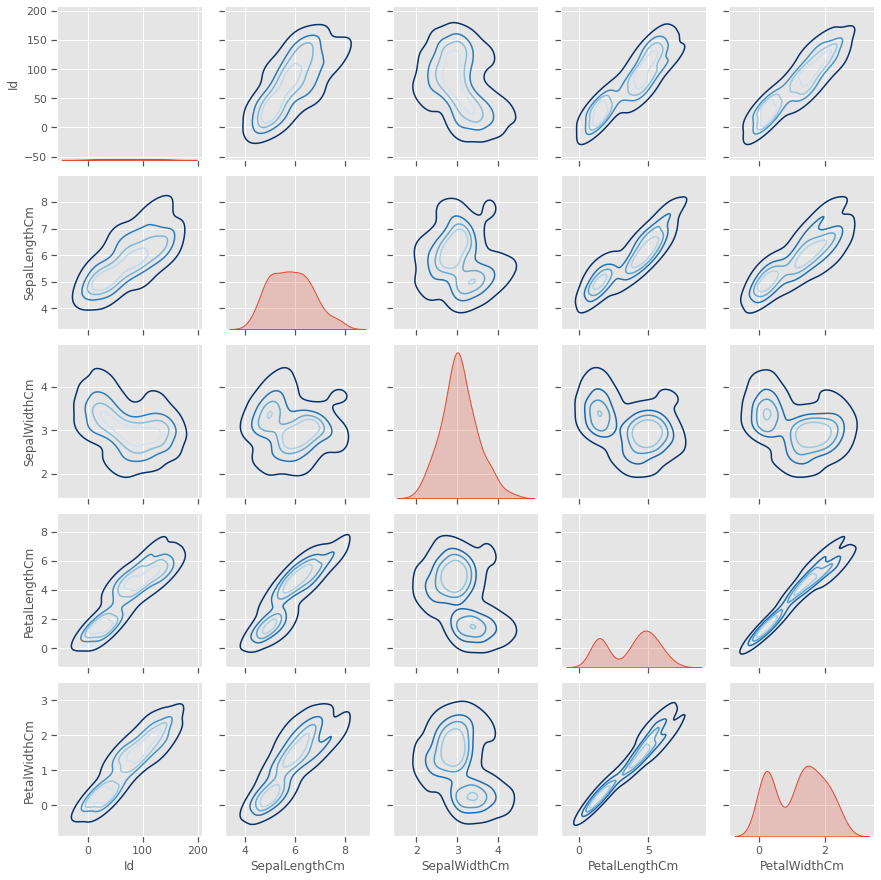

In [64]:
g = sns.PairGrid(iris)
g.map_diag(sns.kdeplot, shade=True)
g.map_offdiag(sns.kdeplot, cmap="Blues_r", n_levels=5)
plt.show()

### Scatter matrix plot

A closer look at individual data points shows that at least one pair of features are discrimatory, but there is no evidence that two features will be sufficient to cluster the three Species, some feature engineering might be needed. This will be investigated further in the visualisation below.

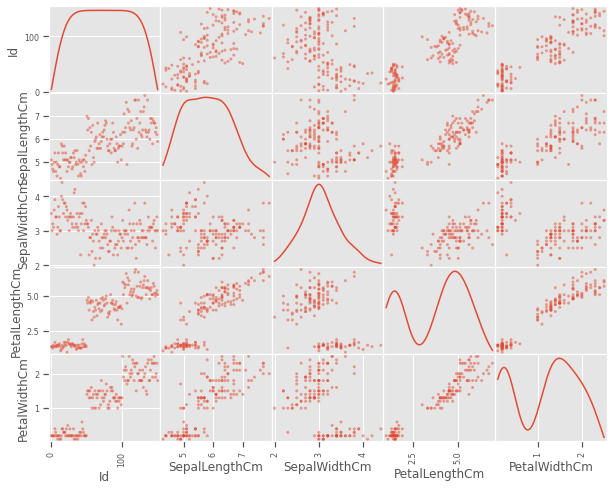

In [65]:
scatter_matrix(iris, figsize=(10,8), diagonal='kde')
plt.show()

### Pairwise plot

A closer look at the Species variations shows that there is a good chance to cluster sepal and petal measurements into the three Species, but versicolor and virginica Species are showing very close resemblance on all variables. This might be challenging for a naive k-means clustering process to optimally cluster these two Species 

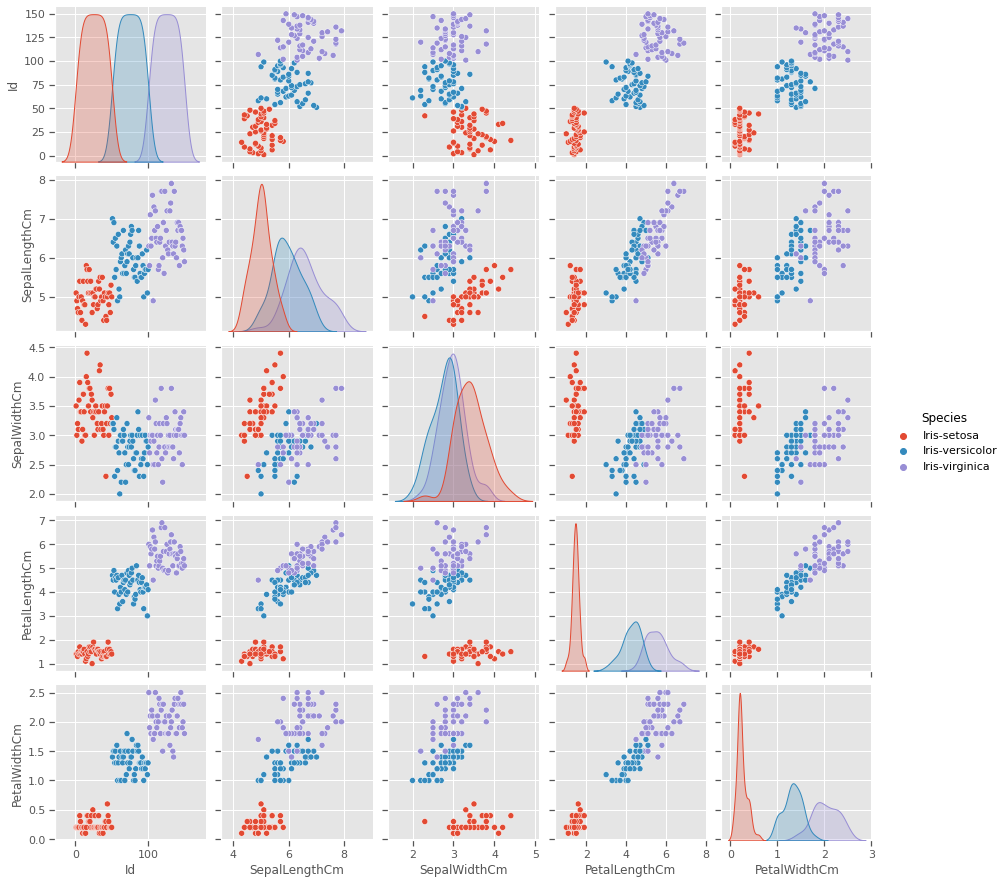

In [66]:
sns.pairplot(iris,hue='Species')
plt.savefig("pairwise.png")
plt.show()

### Radviz plot

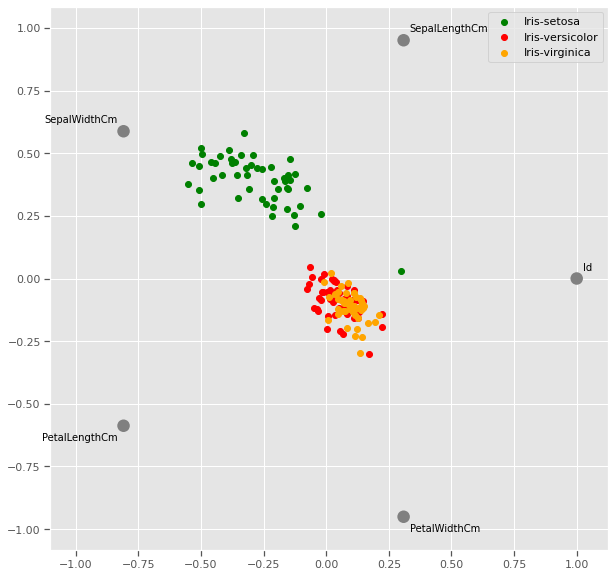

In [67]:
plt.figure(figsize=(10, 10))
radviz(iris, 'Species',color=['Green','Red','Orange'])
plt.savefig("radviz.png")
plt.show()

The Radviz plot helps visualise multi-variate data  based on a simple spring tension minimization algorithm. The set up places points in a plane equally spaced on a unit circle. Each point represents a single attribute. Each sample in the data set is abstractly "attached" to each of these points by a spring, the stiffness of which is proportional to the numerical value of that attribute (they are normalized to unit interval). The point in the plane, where our sample settles to (where the forces acting on our sample are at an equilibrium) is where a dot representing our sample will be drawn. Depending on which class that sample belongs it will be colored differently. 

Virginia and versicolor Species seem to have closely matched feature measurements, and might require a third dimension to cluster.

### Andrews curves

Andrews curves are useful in visualizing multivariate data as a large number of curves that are created using the attributes of samples as coefficients for Fourier series. By coloring these curves differently for each class it is possible to visualize data clustering. Curves belonging to samples of the same class will usually be closer together and form larger structures.

Andrews curves have the functional form of a Fourier series:
```
f(t) = x_1/sqrt(2) + x_2 sin(t) + x_3 cos(t) + x_4 sin(2t) + x_5 cos(2t) + ... 
```
Where x coefficients correspond to the values of each dimension and t is linearly spaced between -pi and +pi. Each row of frame then corresponds to a single curve.

The iris dataset has 2 distinct classes, but the third class is visibly related to one of the other two classes and will require a mathematical model to optimally cluster.

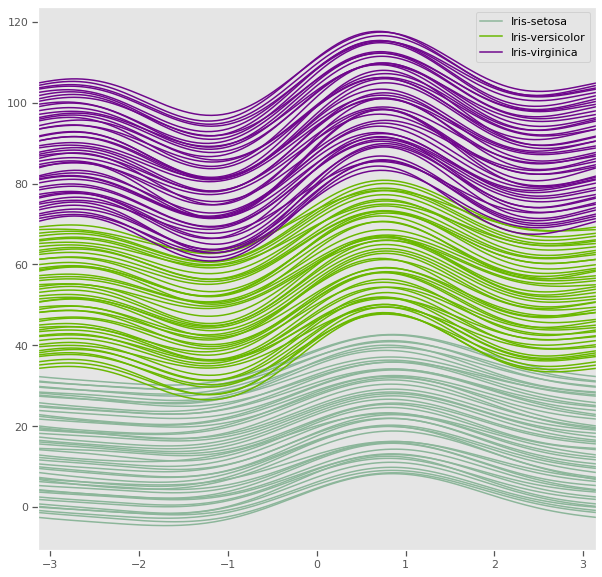

In [68]:
plt.figure(figsize=(10, 10))
andrews_curves(iris, 'Species')
plt.savefig("andrew_curve.png")
plt.show()

### Parallel coordinates

Petal length and petal width has a very strong discriminatory power, while sepal measurements might be very useful together, one might be enough to improve cluster distance

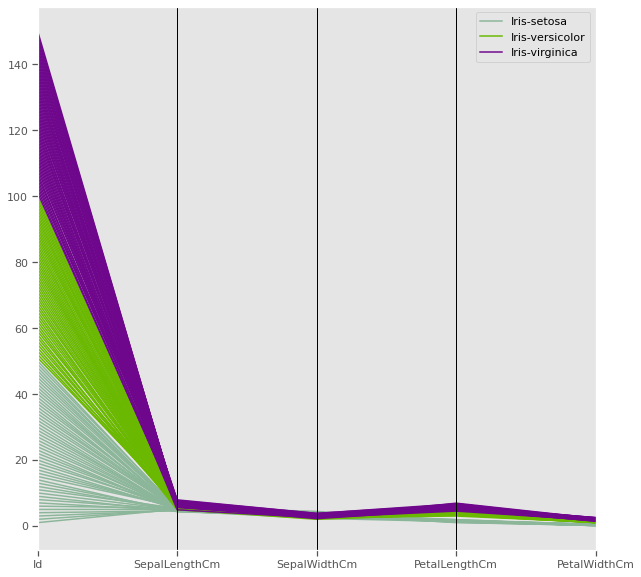

In [69]:
plt.figure(figsize=(10, 10))
parallel_coordinates(iris, 'Species')
plt.show()

---

Parallel coordinates help with visualizing clusters in data and to estimate other statistics visually. Using parallel coordinates points are represented as connected line segments. Each vertical line represents one attribute. One set of connected line segments represents one data point. Points that tend to cluster will appear closer together.

In the iris dataset, Petal length has potential have high discriminatory power for clustering compared to the other three attributes

### Ground truth - Three dimenstional plot

Taking advantage of prior knowlegde about the iris dataset regarding the Species, we can visualise the natural clusters before modelling, as we previously observed in multivariate analysis, at least three variables are sufficient to cluster our flowers into the three different Species

In [70]:
data = iris.copy()
X = data.drop(columns=['Species'])
y = iris['Species'] # k-means does not handle categories, unless labelencoded or dummy variables are created. 
y.unique()

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
Categories (3, object): ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

In [71]:
!pip install orca psutil requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
import plotly.express as px
import plotly
fig = px.scatter_3d(iris, x='PetalLengthCm', y='SepalWidthCm', z='PetalWidthCm',color='Species',title="Iris dataset ground truth")
# fig.write_image("iris_3d.png")
fig.show()

# K-means clustering

The k-means problem is solved using either Lloyd's or Elkan's algorithm, a relatively fast algorithm. The average complexity is given by O(k n T):
 - n is the number of samples
- T is the number of iterations
The worst case complexity is given by O(n^(k+2/p)) with n = n_samples, p = n_features. (D. Arthur and S. Vassilvitskii, 'How slow is the k-means method?' SoCG2006)

Adapted from [official documentation for sklearn](http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html)

As with most statistical algorithms, there are some assumptions, which, if not met, the algorithm will fail dismally. 

For k-means clustering: 
 - Assumption 1: each group will belong to not more than one cluster and that the clusters are of similar/comparable sizes (choose optimum number of clusters)
 - Assumption 2: clusters are spherical and not dependent on direction (not anisotropic) i.e deal with outliers or normalise data

The K-means algorithm aims to choose centroids that *minimise the inertia, or within-cluster sum-of-squares* criterion: 
 
Inertia can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks:
 - Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.

Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as Principal component analysis (PCA) prior to k-means clustering can alleviate this problem and speed up the computations.

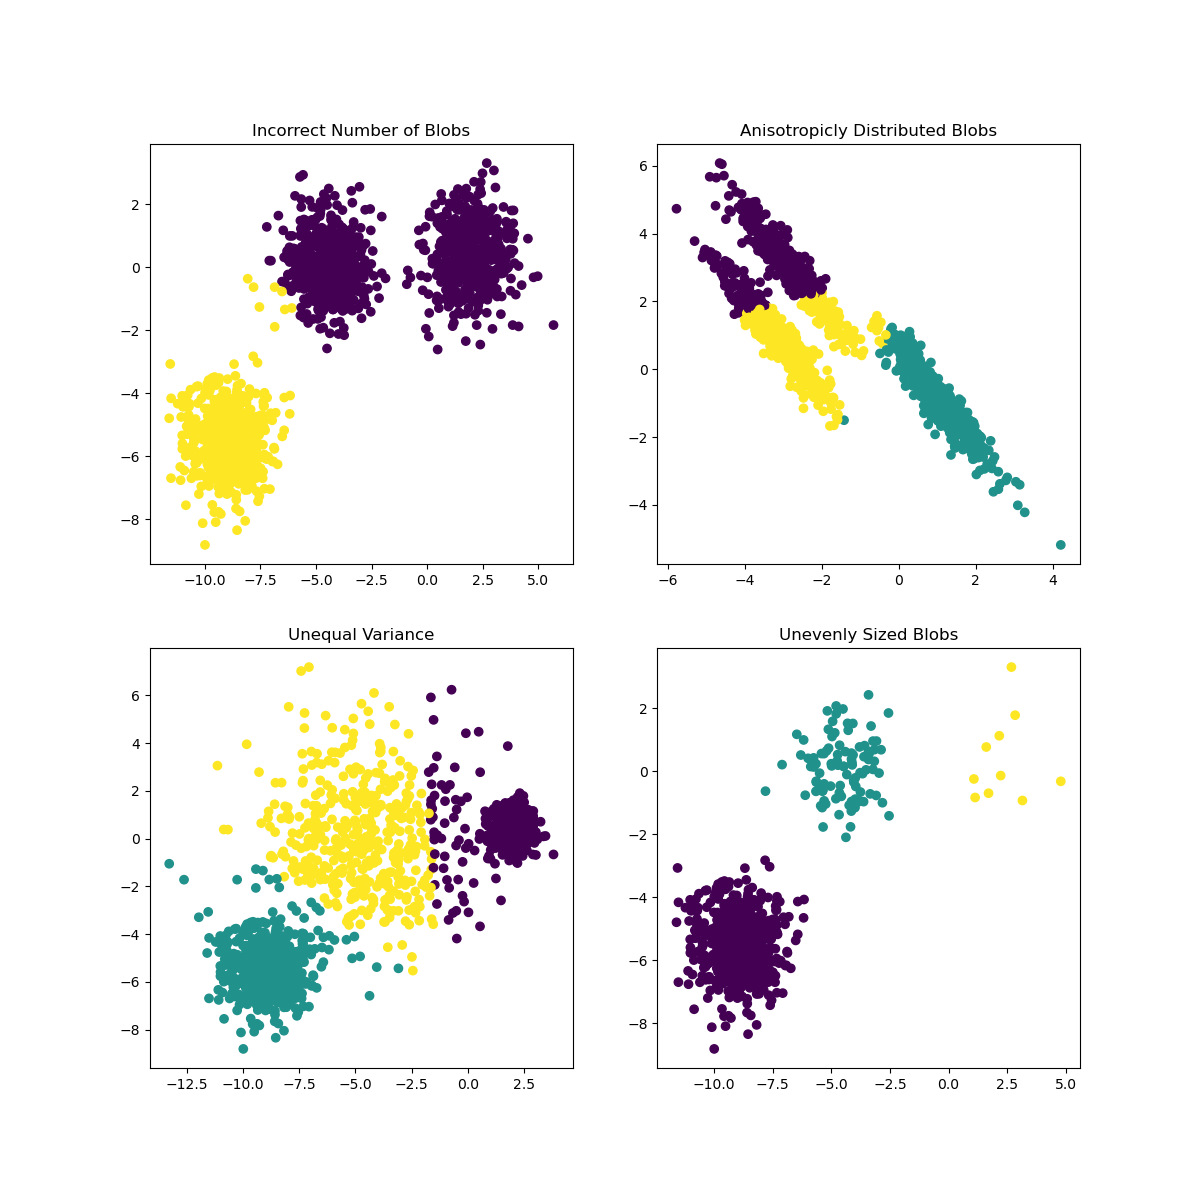

In [73]:
from IPython.display import Image, display
image = 'https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_assumptions_001.png'
display(Image(image,width=700,height=700))

# Optimisation
 - Elbow method
 - Silhoutte method

### Sihlouette method

A higher Silhouette Coefficient indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

Sihlouette outcome: del n_clusters=2: highest Silhouette Coefficient. This suggests that 2 should be the optimal number of cluster

**Ground truth**: Iris dataset has 3 Species, this contradicts the 2 as an optimal number of cluster. So despite n_clusters=2 having highest Silhouette Coefficient

We would consider n_clusters=3 as optimal number of clusters due to: 
 - Iris dataset has 3 Species
 - n_clusters=2 has a 2nd highest value of Silhouette Coefficient.

So choosing n_clusters=3 is the optimal no. of cluster for iris dataset.
This is where EDA and having full context of the dataset really matters.

In [74]:
!pip3 install KMeans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(X)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    print(f"{n_cluster} n_clusters: Silhouette Coefficient = {sil_coeff}")

2 n_clusters: Silhouette Coefficient = 0.6204656046551029
3 n_clusters: Silhouette Coefficient = 0.5821934246576435
4 n_clusters: Silhouette Coefficient = 0.5565212241684705
5 n_clusters: Silhouette Coefficient = 0.5409296814623595
6 n_clusters: Silhouette Coefficient = 0.5323967846020187
7 n_clusters: Silhouette Coefficient = 0.5181139245359432
8 n_clusters: Silhouette Coefficient = 0.5090271671749271
9 n_clusters: Silhouette Coefficient = 0.5099850454239863
10 n_clusters: Silhouette Coefficient = 0.49570845844348127


### Elbow method

The Elbow Method is a method to determine the optimal value of k (number of centroids)

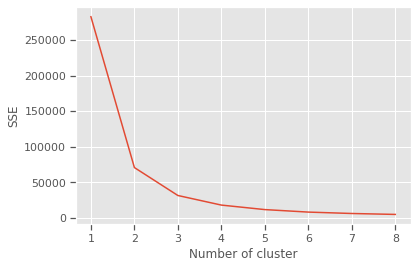

In [80]:
sse = {}
for k in range(1,9):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X)
    X["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Silhouette and Elbow method subplots

For 2 clusters: average silhouette_score is 0.6175133267414747
For 3 clusters: average silhouette_score is 0.5763684631536169
For 4 clusters: average silhouette_score is 0.5478133672654263
For 5 clusters: average silhouette_score is 0.5305889252300955
For 6 clusters: average silhouette_score is 0.5342729732049307
For 7 clusters: average silhouette_score is 0.5343351504011882
For 8 clusters: average silhouette_score is 0.5384539974739627


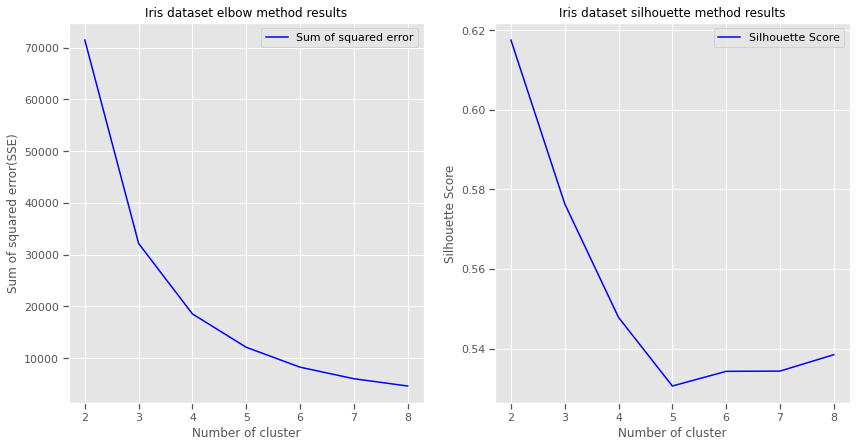

In [81]:
range_n_clusters = range(2,9)
elbow = []
ss = []
for n_clusters in range_n_clusters:
   #iterating through cluster sizes
   clusterer = KMeans(n_clusters = n_clusters, random_state=42)
   cluster_labels = clusterer.fit_predict(X)
   #Finding the average silhouette score
   silhouette_avg = silhouette_score(X, cluster_labels)
   ss.append(silhouette_avg)
   print(f"For {n_clusters} clusters: average silhouette_score is {silhouette_avg}")
   #Finding the average SSE"
   elbow.append(clusterer.inertia_) # Inertia: Sum of distances of samples to their closest cluster center

fig = plt.figure(figsize=(14,7))

fig.add_subplot(121)
plt.title("Iris dataset elbow method results")
plt.plot(range_n_clusters, elbow,'b-',label='Sum of squared error')
plt.xlabel("Number of cluster")
plt.ylabel("Sum of squared error(SSE)")
plt.legend()

fig.add_subplot(122)
plt.title("Iris dataset silhouette method results")
plt.plot(range_n_clusters, ss,'b-',label='Silhouette Score')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

# Train model

 - *n_init* Number of times algorithm will be run with different centroid seeds.Results will be best inertia output. Setting n_init to 1 (default is 10), reduces the amount of times algorithm will be run with different centroid seeds is reduced.
 - *n_clusters*: based on Elbow and Silhouette method results
 - *algorithm*: "elkan" or "auto" or "full".  The classical EM-style (Lloyd's) algorithm is "full".  The "elkan" variation is more efficient by using the triangle inequality, but currently doesn't support sparse data. "auto" chooses  "elkan" for dense data and "full" for sparse data.

 - *max_iter*: the k-means algorithm is generally very fast, but it falls on a  local minima. That's why it can be useful to restart it several times. If the algorithm stops before fully converging (because of tol or max_iter), labels_ and cluster_centers_ will not be consistent, i.e. the cluster_centers_ will not be the means of the points in each cluster. Also, the estimator will reassign labels_ after the last iteration to make labels_ consistent with predict on the training set.

In [78]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3,n_init=1,init='random', max_iter=10000, random_state=21,algorithm="auto")
fitted_model = model.fit(X)
labels = model.labels_
centers = pd.DataFrame(fitted_model.cluster_centers_)
print(f'Cluster centers: \n {centers}')

Cluster centers: 
        0         1         2         3         4         5
0  125.0  6.570588  2.970588  5.523529  2.011765  2.254902
1   74.5  5.922000  2.780000  4.206000  1.304000  3.780000
2   25.0  5.006122  3.420408  1.465306  0.244898  4.265306


# Visualise predictions: k-means

The iris dataset is a great dataset to demonstrate some of the shortcomings of k-means clustering. This dataset also presents a great opportunity to highlight the importance of exploratory data analysis to understand the data and gain more insights about the data before deciding which clustering algorithm to use and whether or a model is necessary to group the data. 

Without prior knowledge of the Species of iris flowers in this dataset, multivariate analysis was proven to be an ineffective way to cluster the iris dataset. Clustering seemed like a good candidate for grouping the iris dataset.However, the results in the case of the iris dataset show that two out of the three Species are difficult to cluster because their clusters are not spherical and are elongated (anisotropic) in the possible direction clusters can form. Based on the ground truth evidence, and prior knowledge of the Species, from the 3D plot, it is evidenced that k-means cluster was not able to improve clustering of the three iris Species in the dataset. A dimensionality reduction using Principal Component analysis might improve the efficiency of the k-means clustering algorithm, used independently, it will not produce good enough clusters.

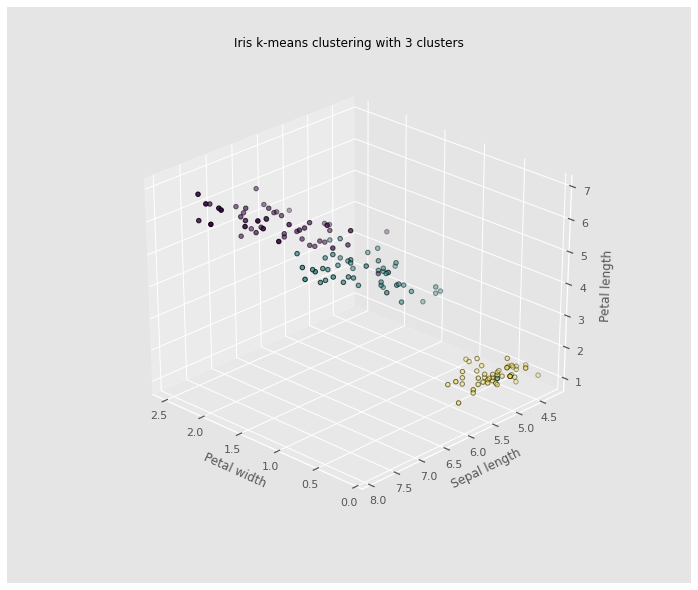

In [79]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig, 
            rect=[0, 0, .95, 1], 
            elev=30, 
            azim=134)
model.fit(X)
labels = model.labels_

ax.set_title("Iris k-means clustering with 3 clusters")
ax.scatter(X["PetalWidthCm"], X["SepalLengthCm"], X["PetalLengthCm"],c=labels.astype(np.float), edgecolor='k')
ax.set_xlabel('Petal width',labelpad=10)
ax.set_ylabel('Sepal length',labelpad=10)
ax.set_zlabel('Petal length',labelpad=10)
ax.dist = 13
plt.savefig("kclusters.png")